In [1]:
import pandas as pd
import numpy as np

import glob

import seaborn as sns
sns.reset_orig()

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['image.cmap'] = 'hot_r'
from matplotlib.colors import LogNorm

from scipy.optimize import curve_fit
from scipy.stats import iqr
from scipy.stats import binned_statistic, binned_statistic_2d
from scipy.stats import norm

%matplotlib inline

In [2]:
# from matplotlib import rcParams
# rcParams['font.family'] = 'sans-serif'
# rcParams['font.sans-serif'] = ['Fira Sans']

In [3]:
#mpl.rcParams.update({'font.size': 20})

In [4]:
font = {'family' : 'Apple Symbols',
        'weight' : 'normal',
        'size'   : 20}

mpl.rc('font', **font)

In [5]:
def gauss_function(x, a, x0, sigma):
    return a*np.exp(-(x-x0)**2/(2*sigma**2))

In [6]:
def tw_func(x, a, b, c, d):
    return a*x + b + c / (x - d)

In [7]:
#fname = '/tmp/alobanov/TOA_calib_part.h5'
#fname = '/tmp/alobanov/TOA_calib_full.h5'
#fname = '/Users/artur/cernbox/SWAN_projects/CERNTB/TOA/TOA_calib_full.h5'
fname = './TOA_calib_full_new2.h5'

In [8]:
%%time
columns = [u'rechit_chip_id', u'rechit_channel', u'rechit_energy', u'rechit_chan_id',
           u'rechit_toaRise_norm', u'rechit_toaFall_norm','rechit_amplitudeLow',
           u'toa_rise_time', u'tw_corr', u'toa_rise_calib']

df = pd.read_hdf(fname, columns = columns, key='/table')

CPU times: user 6 s, sys: 3.63 s, total: 9.63 s
Wall time: 14.2 s


In [9]:
df['rechit_layer'] = df.rechit_chip_id // 4
df['run'] = df.index//1e6
df['run'] = df['run'].astype('int')

#### HACK
df.toa_rise_time = df.toa_rise_calib

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 12059236 entries, 235000002.0 to 399050047.0
Data columns (total 12 columns):
rechit_chip_id         uint32
rechit_channel         uint32
rechit_energy          float32
rechit_chan_id         uint32
rechit_toaRise_norm    float64
rechit_toaFall_norm    float64
rechit_amplitudeLow    float32
toa_rise_time          float64
tw_corr                float64
toa_rise_calib         float64
rechit_layer           uint32
run                    int64
dtypes: float32(2), float64(5), int64(1), uint32(4)
memory usage: 920.0 MB


### Time layer

In [11]:
%%time
columns = [u'rechit_chip_id', 'run', u'rechit_channel', 'toa_rise_time', 'toa_fall_time']
#tref_fname = './time_layer_test.h5'
#tref_fname = 'timeref/time_layer_test_runs_240_263.h5'
#tref_fname = 'timeref/time_layer_test_runs_310_350.h5'
tref_fname = 'timeref/test.h5'
df_tref = pd.read_hdf(tref_fname, columns = columns, key='/table')

CPU times: user 3.44 s, sys: 2.32 s, total: 5.75 s
Wall time: 10.3 s


In [12]:
#### HACK
df_tref.toa_rise_time = 25 - df_tref.toa_rise_time

In [13]:
df_tref.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 8607465 entries, 310000001.0 to 399050047.0
Data columns (total 5 columns):
rechit_chip_id    int32
run               int64
rechit_channel    int32
toa_rise_time     float64
toa_fall_time     float64
dtypes: float64(2), int32(2), int64(1)
memory usage: 328.3 MB


## Timing reference layer

In [14]:
##Create df for single reference channel 

ref_layer = 29

ref_chip = 4*ref_layer + 2
ref_chan = 38

sel = df_tref.toa_rise_time > 0
sel &= df_tref.rechit_chip_id == ref_chip
sel &= df_tref.rechit_channel == ref_chan

cols = ['run', 'toa_rise_time', 'toa_fall_time']
df_tref_ch = df_tref[sel][cols]

In [15]:
df_tref_ch.head()

run  toa_rise_time  toa_fall_time
event                                         
310000001.0  310      14.563360      22.527594
310000002.0  310      11.238189       1.096713
310000003.0  310       1.430094      11.216516
310000004.0  310       2.468468      10.166660
310000005.0  310       1.913034      10.730579

In [16]:
len(df_tref_ch)

1075926

In [17]:
# ref_layer = 29

# ref_chip1 = 4*ref_layer + 2
# ref_chan1 = 38

# ref_chip2 = 4*ref_layer + 3
# ref_chan2 = 38

# sel = df_tref.toa_rise_time > 0
# sel &= df_tref.rechit_chip_id == ref_chip1
# #sel &= df_tref.rechit_Tot > 500
# #sel &= df_tref.run < 294

# df_tref_ch1 = df_tref[sel & (df_tref.rechit_channel == ref_chan1)].copy()

# sel = df_tref.toa_rise_time > 0
# sel &= df_tref.rechit_chip_id == ref_chip2
# #sel &= df_tref.rechit_Tot > 500
# #sel &= df_tref.run < 294

# df_tref_ch2 = df_tref[sel & (df_tref.rechit_channel == ref_chan2)].copy()

# df_tref_join = df_tref_ch1.join(df_tref_ch2, lsuffix='_ch1', rsuffix='_ch2')

# # df_tref_join.dropna(inplace = True)
# # df_tot_join =  df_tot_join[df_tot_join.run < 293]

# print len(df_tref_join), ' entries'

### Join reference time to main df

In [18]:
%%time
df_tot_join = df.join(df_tref_ch, lsuffix='', rsuffix='_ref', how='inner')

CPU times: user 5.35 s, sys: 4.85 s, total: 10.2 s
Wall time: 15.4 s


### Calculate channel wise offsets to reference

In [20]:
df_tot_join['deltaT_ref'] = df_tot_join.toa_rise_time - df_tot_join.toa_rise_time_ref

In [22]:
df_tot_join.run.unique()

array([310, 312, 313, 314, 315, 316, 318, 319, 320, 321, 323, 326, 328,
       330, 331, 333, 335, 336, 338, 339, 340, 342, 343, 344, 346, 347,
       349, 350, 351, 353, 363, 365, 366, 367, 369, 371, 372, 373, 374,
       375, 376, 378, 380, 381, 393, 394, 395, 396, 399])

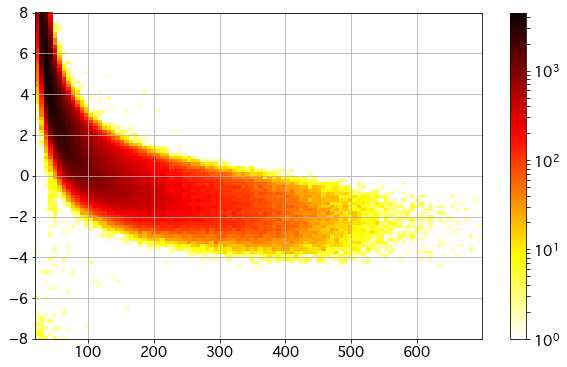

In [23]:
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 8
sel &= df_tot_join.rechit_energy > 20
sel &= df_tot_join.rechit_energy < 700

sel &= df_tot_join.rechit_channel == 36

#sel &= df_tot_join.run < 380

plt.hist2d(df_tot_join[sel].rechit_energy, df_tot_join[sel].deltaT_ref, bins = 100,  norm = LogNorm())

plt.colorbar()
plt.grid()

### Calculate offsets wrt TRef (for energy windows 100±5 MIP)

In [25]:
sel = abs(df_tot_join.rechit_energy - 100) < 5
sel &= abs(df_tot_join['deltaT_ref']) < 5

offs = df_tot_join[sel].groupby('rechit_chan_id')['deltaT_ref'].median()

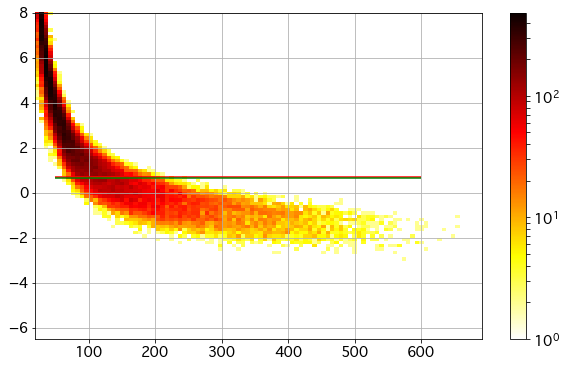

In [26]:
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 8
sel &= df_tot_join.rechit_energy > 20
sel &= df_tot_join.rechit_energy < 700

sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 1

plt.hist2d(df_tot_join[sel].rechit_energy, df_tot_join[sel].deltaT_ref, bins = 100,  norm = LogNorm())

sel = abs(df_tot_join.rechit_energy - 100) < 5
sel &= abs(df_tot_join['deltaT_ref']) < 5

off = df_tot_join[sel]['deltaT_ref'].mean()
plt.hlines(off, 50, 600, colors = 'r')

off = df_tot_join[sel]['deltaT_ref'].median()
plt.hlines(off, 50, 600, colors = 'g')


plt.colorbar()
plt.grid()

Look at the offsets

In [27]:
df_offs = pd.DataFrame(offs)
df_offs.reset_index(inplace = True)

In [29]:
df_offs['chan_id'] = df_offs.rechit_chan_id%64
df_offs['chip_id'] = (df_offs.rechit_chan_id - df_offs.chan_id)/64
df_offs['chip'] = df_offs.chip_id%4
df_offs['layer'] = df_offs.chip_id//4

In [30]:
df_tot_join['ref_offset'] = 0
df_tot_join['ref_offset'] = df_tot_join['rechit_chan_id'].map(offs.to_dict())

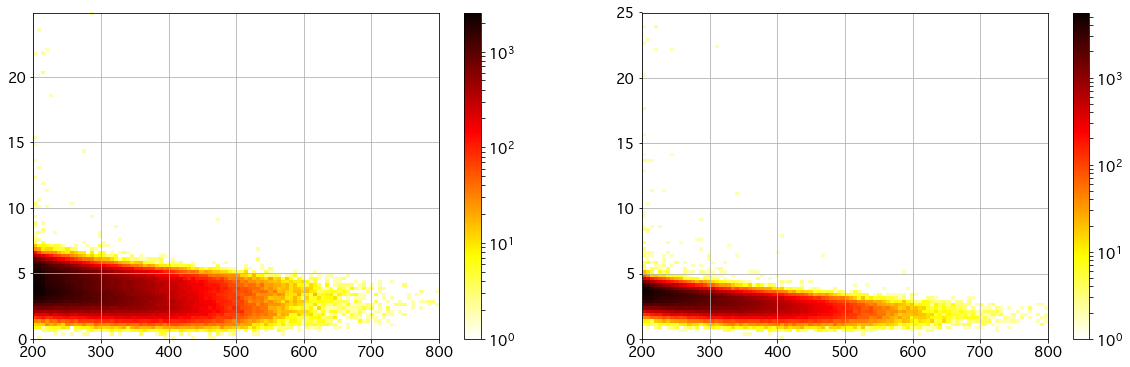

In [31]:
plt.figure(figsize = (20,6))

sel = abs(df_tot_join.deltaT_ref) < 25

# sel &= df_tot_join.deltaT_ref > -5
# sel &= df_tot_join.deltaT_ref < 20

sel &= df_tot_join.rechit_energy > 200
sel &= df_tot_join.rechit_energy < 800

#sel &= df_tot_join.rechit_channel == 36
#sel &= df_tot_join.rechit_layer == 7

sel &= df_tot_join.ref_offset > -10

x = df_tot_join[sel].rechit_energy

plt.subplot(121)
y = (df_tot_join[sel].deltaT_ref + 5)%25

plt.hist2d(x,y, bins = 100,  norm = LogNorm())

plt.colorbar()
plt.grid()

plt.subplot(122)
y = (df_tot_join[sel].deltaT_ref - df_tot_join[sel].ref_offset + 5)%25

plt.hist2d(x,y, bins = 100,  norm = LogNorm())

plt.colorbar()
plt.grid()

In [37]:
def stitched_tw_profile(x,y, bins1 = 100, bins2 = 100, y_sep = 5):
    
    ### dt vs X
    x_mean1,y_mean1 = binned_statistic(x, [x,y], bins=bins1, statistic='median').statistic
    x_err1,y_err1 = binned_statistic(x, [x,y], bins=bins1, statistic=iqr).statistic / 1.35

    ### X vs dt
    x_mean2,y_mean2 = binned_statistic(y, [x,y], bins=bins2, statistic='median').statistic
    x_err2,y_err2 = binned_statistic(y, [x,y], bins=bins2, statistic=iqr).statistic / 1.35
    
    nan_idxs = np.isnan(x_mean1 * y_mean1 * y_err1)
    x_mean1 = x_mean1[~nan_idxs]; y_mean1 = y_mean1[~nan_idxs]; y_err1 = y_err1[~nan_idxs]

    #sel1 = x_mean1 >= x_sep; #sel1 &= x_mean1 < 300
    sel1 = y_mean1 < y_sep
    sel1 &= y_mean1 > 0
    #sel1 &= y_mean1 < 15

    nan_idxs = np.isnan(x_mean2 * y_mean2 * y_err2)
    x_mean2 = x_mean2[~nan_idxs]; y_mean2 = y_mean2[~nan_idxs]; y_err2 = y_err2[~nan_idxs]

    #sel2 = x_mean2 < x_sep; #sel2 &= x_mean2 < 600
    sel2 = y_mean2 >= y_sep
    sel2 &= y_mean2 > 0
    #sel2 &= y_mean2 < 15

    x_comb = np.append(x_mean1[sel1], x_mean2[sel2])
    y_comb = np.append(y_mean1[sel1], y_mean2[sel2])

    y_comb_err = np.append(y_err1[sel1], y_err2[sel2])

    sort_idx = x_comb.argsort()
    x_comb = x_comb[sort_idx]
    y_comb = y_comb[sort_idx]
    y_comb_err = y_comb_err[sort_idx]

    return x_comb, y_comb, y_comb_err

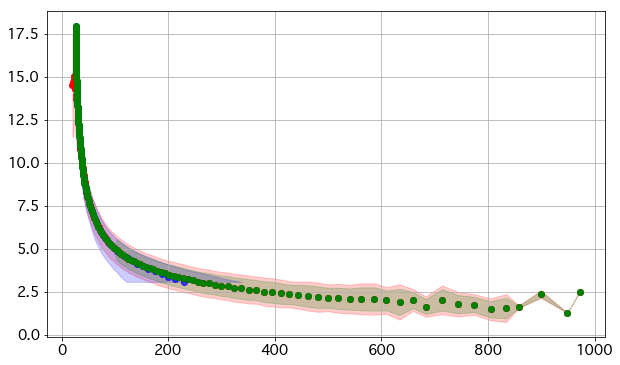

In [39]:
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 25

# sel &= df_tot_join.deltaT_ref > -5
# sel &= df_tot_join.deltaT_ref < 20

sel &= df_tot_join.rechit_energy > 10
#sel &= df_tot_join.rechit_energy < 800

sel &= df_tot_join.rechit_channel == 36
#sel &= df_tot_join.rechit_layer == 7

sel &= df_tot_join.ref_offset > -10

x = df_tot_join[sel].rechit_energy
y = (df_tot_join[sel].deltaT_ref - df_tot_join[sel].ref_offset + 5)%25

bins1 = np.logspace(np.log10(20),np.log10(1000),100)
bins2 = np.linspace(3,18,100)


### dt vs LG
x_mean1,y_mean1 = binned_statistic(x, [x,y], bins=bins1, statistic='median').statistic
x_err1,y_err1 = binned_statistic(x, [x,y], bins=bins1, statistic=iqr).statistic

plt.plot(x_mean1, y_mean1, 'ro', label = 'dT vs E profile')
plt.fill_between(x_mean1, y_mean1 - y_err1, y_mean1 + y_err1, alpha = 0.2, color =  'r')

### LG vs dt
x_mean2,y_mean2 = binned_statistic(y, [x,y], bins=bins2, statistic='median').statistic
x_err2,y_err2 = binned_statistic(y, [x,y], bins=bins2, statistic=iqr).statistic

plt.plot(x_mean2, y_mean2, 'bo', alpha = 0.7, label = 'E vs dT profile')
plt.fill_betweenx(y_mean2, x_mean2 - x_err2, x_mean2 + x_err2, alpha = 0.2, color = 'b')

## get stitched profile

x_mean, y_mean, y_err = stitched_tw_profile(x,y,bins1,bins2, 5)
plt.plot(x_mean, y_mean, 'go', label = 'Combined')
plt.fill_between(x_mean, y_mean - y_err, y_mean + y_err, alpha = 0.2, color =  'g')


plt.grid()

[1.7548633699982973e-21, 1.7342414727336972, 298.11139246529467, 2.89475844738019]


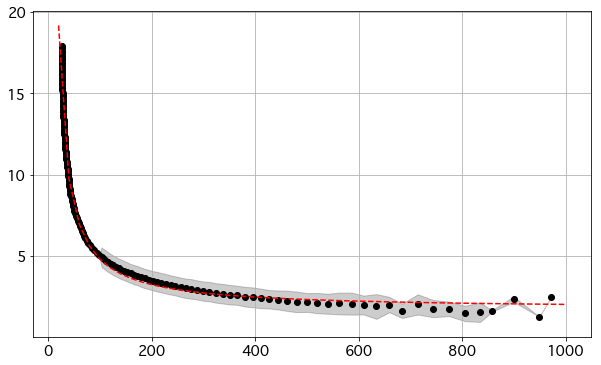

In [42]:
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 25
# sel &= df_tot_join.deltaT_ref > -5
# sel &= df_tot_join.deltaT_ref < 20

sel &= df_tot_join.rechit_energy > 10
#sel &= df_tot_join.rechit_energy < 800

sel &= df_tot_join.rechit_channel == 36
#sel &= df_tot_join.rechit_layer == 7

sel &= df_tot_join.ref_offset > -10

x = df_tot_join[sel].rechit_energy
y = (df_tot_join[sel].deltaT_ref - df_tot_join[sel].ref_offset + 5)%25

bins1 = np.logspace(np.log10(20),np.log10(1000),100)
bins2 = np.linspace(3,18,100)

## get stitched profile
x_mean, y_mean, y_err = stitched_tw_profile(x,y,bins1,bins2, 5)
plt.plot(x_mean, y_mean, 'ko', label = 'Combined')
plt.fill_between(x_mean, y_mean - y_err, y_mean + y_err, alpha = 0.2, color =  'k')

sel = y_mean < 13
tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            #sigma = 1/y_err2[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
xs = np.linspace(20,1000)
plt.plot(xs,tw_func(xs,*tw_params), 'r--')

print tw_params

plt.grid()

Fit params [6.455800390230081e-16, 3.6104027485453853, 152.13489145889028, 14.27100679208545]
Fit params [7.560105692274008e-20, 2.0156143471539574, 309.3684622034637, -2.4932965377035647]
Fit params [2.025229062374272e-17, 1.1176790822298381, 627.7903129475352, -62.76148793188367]


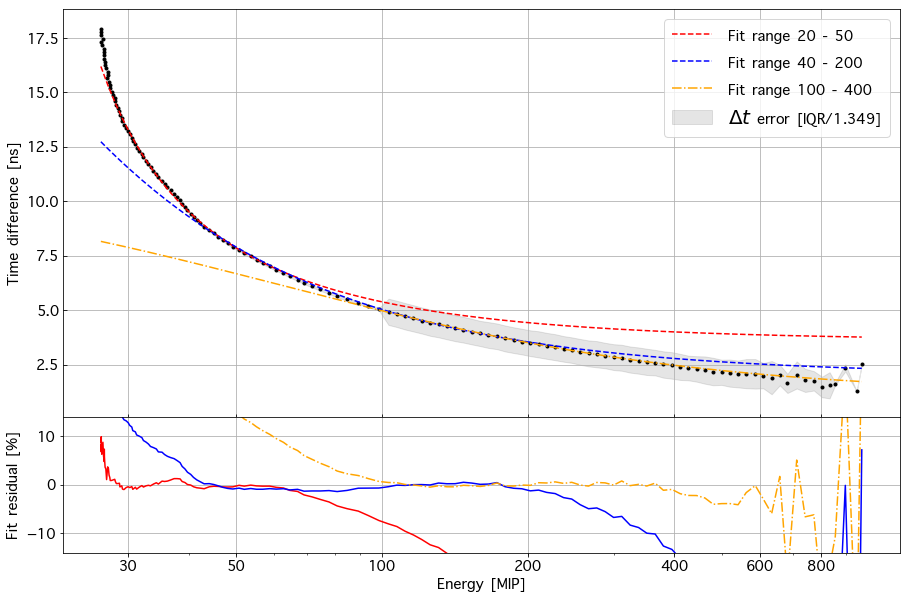

In [43]:
f, axs = plt.subplots(2, sharex=True, figsize = (15,10), gridspec_kw = {'height_ratios':[3,1]})

axs[0].plot(x_mean, y_mean, '.k')
axs[0].fill_between(x_mean, y_mean - y_err, y_mean + y_err,
                    alpha = 0.1, color = 'k', label = r'$\Delta t$ error [IQR/1.349]' )

# for func plotting
xs = np.linspace(min(x_mean),max(x_mean), 1000)

## fit range selection
min_x = 20; max_x = 50
sel = (y_mean < 15) & (y_mean > 0)
sel &= (x_mean > min_x) & (x_mean < max_x)

tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            sigma = 1/y_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), 'r--',label = 'Fit range %i - %i' % (min_x, max_x))
axs[1].plot(x_mean,(y_mean - tw_func(x_mean,*tw_params))/y_mean*100., 'r')

print 'Fit params', tw_params

## fit range selection
min_x = 40; max_x = 200
sel = (y_mean < 15) & (y_mean > 0)
sel &= (x_mean > min_x) & (x_mean < max_x)

tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            sigma = 1/y_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), 'b--',label = 'Fit range %i - %i' % (min_x, max_x))
axs[1].plot(x_mean,(y_mean - tw_func(x_mean,*tw_params))/y_mean*100., 'b')

print 'Fit params', tw_params

## fit range selection
min_x = 100; max_x = 400
sel = (y_mean < 15) & (y_mean > 0)
sel &= (x_mean > min_x) & (x_mean < max_x)

tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            sigma = 1/y_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), '-.',color = 'orange',label = 'Fit range %i - %i' % (min_x, max_x))
axs[1].plot(x_mean,(y_mean - tw_func(x_mean,*tw_params))/y_mean*100., '-.',color = 'orange')

print 'Fit params', tw_params

### set up plot
f.subplots_adjust(hspace=0)

#axs[0].set_yscale('log'); axs[0].set_ylim(5,16)

axs[0].grid()
axs[0].legend()
axs[0].tick_params(direction = 'in')
axs[0].set_ylabel('Time difference [ns]')

#axs[0].set_xlim(120,300); axs[1].set_xlim(120,300)

axs[1].set_ylim(-14,14)
axs[1].grid()

axs[1].set_xlabel('Energy [MIP]')
axs[1].set_ylabel('Fit residual [%]')

## log x
axs[0].set_xscale('log')#; axs[1].set_xscale('log')
axs[0].set_xticks([30,50,100,200,400,600,800])
axs[0].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


plt.show()

[4.431935881948466e-20, 1.6037142138196876, 316.9831616434901, 1.2890011161781114]
[1.361920226215465e-20, 1.9406383835365155, 278.82633230095536, 1.6977959561573766]


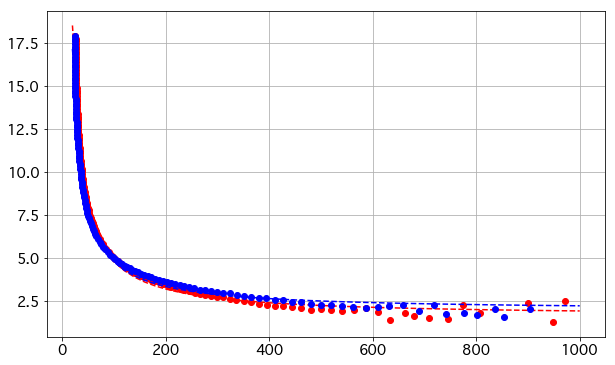

In [47]:
plt.figure(figsize = (10,6))

bins1 = np.logspace(np.log10(20),np.log10(1000),100)
bins2 = np.linspace(3,18,100)

sel = abs(df_tot_join.deltaT_ref) < 25
sel &= df_tot_join.rechit_energy > 10
sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 7

#sel &= df_tot_join.ref_offset > -10

x = df_tot_join[sel].rechit_energy
y = (df_tot_join[sel].deltaT_ref - df_tot_join[sel].ref_offset + 5)%25

## get stitched profile
x_mean, y_mean, y_err = stitched_tw_profile(x,y,bins1,bins2, 5)
plt.plot(x_mean, y_mean, 'ro', label = 'Chan 1')
#plt.fill_between(x_mean, y_mean - y_err, y_mean + y_err, alpha = 0.2, color =  'k')

sel = y_mean < 13
tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
xs = np.linspace(20,1000)
plt.plot(xs,tw_func(xs,*tw_params), 'r--')

print tw_params



#### Second channel
sel = abs(df_tot_join.deltaT_ref) < 25
sel &= df_tot_join.rechit_energy > 10
sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8

#sel &= df_tot_join.ref_offset > -10

x = df_tot_join[sel].rechit_energy
y = (df_tot_join[sel].deltaT_ref - df_tot_join[sel].ref_offset + 5)%25

## get stitched profile
x_mean, y_mean, y_err = stitched_tw_profile(x,y,bins1,bins2, 5)
plt.plot(x_mean, y_mean, 'bo', label = 'Chan 2')
#plt.fill_between(x_mean, y_mean - y_err, y_mean + y_err, alpha = 0.2, color =  'k')

sel = y_mean < 13
tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
xs = np.linspace(20,1000)
plt.plot(xs,tw_func(xs,*tw_params), 'b--')

print tw_params

plt.grid()

28 2188 [4.33233085e-19 1.79184129e+00 1.94698149e+02 1.24626999e+01]
29 111394 [2.24751168e-20 2.24648461e+00 1.49248336e+02 1.67213935e+01]
30 143234 [1.19993481e-17 1.99143006e+00 1.80693277e+02 1.16489599e+01]
31 90128 [8.18111324e-21 1.98451231e+00 1.72981408e+02 1.38381060e+01]
32 2095 [5.63598722e-17 2.02675886e+00 1.86235569e+02 1.07738299e+01]
33 96086 [2.52054190e-20 2.19974332e+00 1.64244826e+02 1.05259768e+01]
34 125756 [8.78522865e-21 2.15159165e+00 1.59539267e+02 1.12222952e+01]
35 111787 [1.09178656e-20 1.79177069e+00 1.92135066e+02 1.10146727e+01]
36 2182 [2.82281933e-16 2.19654040e+00 1.48801147e+02 1.36773879e+01]
37 127247 [2.60149794e-21 1.79132995e+00 1.87939991e+02 1.50034556e+01]
38 137850 [2.92710230e-18 1.88854361e+00 1.83555314e+02 1.41021281e+01]
39 106677 [1.30816260e-16 1.93050175e+00 1.73670918e+02 1.48276698e+01]
CPU times: user 5.06 s, sys: 348 ms, total: 5.4 s
Wall time: 5.68 s


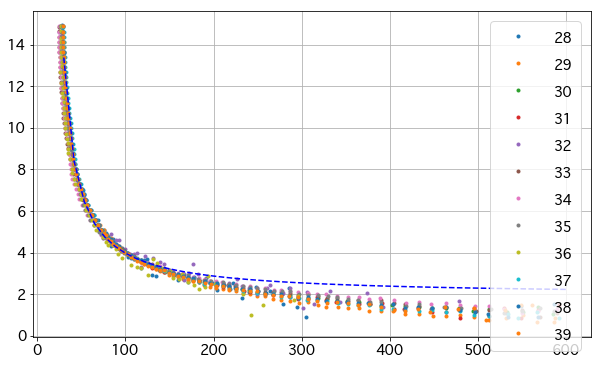

In [81]:
%%time
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 25
sel &= df_tot_join.rechit_energy > 20

sel &= df_tot_join.rechit_channel == 36
#sel &= df_tot_join.rechit_layer == 8
#sel &= df_tot_join.rechit_chip_id%4 == 2
df_sel = df_tot_join[sel]
chips = np.sort(df_sel.rechit_chip_id.unique())

## x = energy
bins1 = np.logspace(np.log10(20),np.log10(600),100)
#bins1 = np.linspace(20,800,150)
xval = 'rechit_energy'

## x = LG
# bins1 = np.logspace(np.log10(100),np.log10(2000),100)
# xval = 'rechit_amplitudeLow'

## y
bins2 = np.linspace(3,15,50)
yval = 'deltaT_ref'


for chip in chips:#[:5]:
    chan_sel = df_sel.rechit_chip_id == chip
    
    print chip, np.count_nonzero(chan_sel),

    x = df_sel[chan_sel][xval]
    y = (df_sel[chan_sel][yval] - df_sel[chan_sel].ref_offset + 4)%25
    
    x_mean, y_mean, y_err = stitched_tw_profile(x,y,bins1,bins2, 5)
    plt.plot(x_mean, y_mean, '.', label = str(chip))#, mfc = 'none')
    
    sel = y_mean > 3
    tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )
    
    print tw_params
    
tw_params = tw_params.tolist()
xs = np.linspace(30,600)
plt.plot(xs,tw_func(xs,*tw_params), 'b--')
    
plt.legend()
plt.grid()

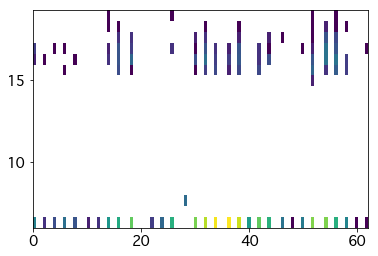

In [112]:
sel = df_tot_join.rechit_energy > 20

#sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 3

sel &= df_tot_join.rechit_amplitudeLow > 750
sel &= df_tot_join.rechit_amplitudeLow < 800

#sel &= df_tot_join.rechit_amplitudeLow / df_tot_join.rechit_energy > 8

plt.hist2d(df_tot_join[sel].rechit_channel,
           df_tot_join[sel].rechit_amplitudeLow / df_tot_join[sel].rechit_energy,
           (100, 20), norm = LogNorm(), cmap = 'viridis')
plt.show()

0 20099 [6.04241292e-20 3.37300181e+00 5.34366037e+02 6.87909270e+01]
2 19719 [2.17361804e-19 3.38509268e+00 5.51743557e+02 6.63542864e+01]
4 7582 [1.25233528e-20 3.52167908e+00 5.45012347e+02 6.97206170e+01]
6 2637 [7.66443218e-16 3.51322457e+00 5.59731274e+02 6.83572691e+01]
8 2937 [2.17996821e-18 3.08129324e+00 6.46056899e+02 6.31263965e+01]
10 2126 [8.45231283e-18 3.13530779e+00 5.63163309e+02 7.10566662e+01]
12 311 [4.14723004e-17 3.82862927e+00 4.83214284e+02 5.18737255e+01]
14 1367 [1.30028798e-14 2.74921390e+00 7.62652991e+02 5.44953569e+01]
16 527 [7.02644105e-18 2.97094242e+00 6.03220161e+02 4.93406445e+01]
18 5220 [3.87760037e-17 3.11296358e+00 6.13625010e+02 6.49780340e+01]
20 13641 [1.58616350e-21 3.52700101e+00 5.60279652e+02 6.89475205e+01]
22 43100 [1.56357609e-21 3.52777238e+00 5.70433749e+02 6.90903997e+01]
24 47659 [1.00700178e-18 3.41705863e+00 5.76066133e+02 6.48512471e+01]
26 91189 [9.76934997e-18 3.33542817e+00 6.03844197e+02 6.59043252e+01]
28 72455 [2.56294623e

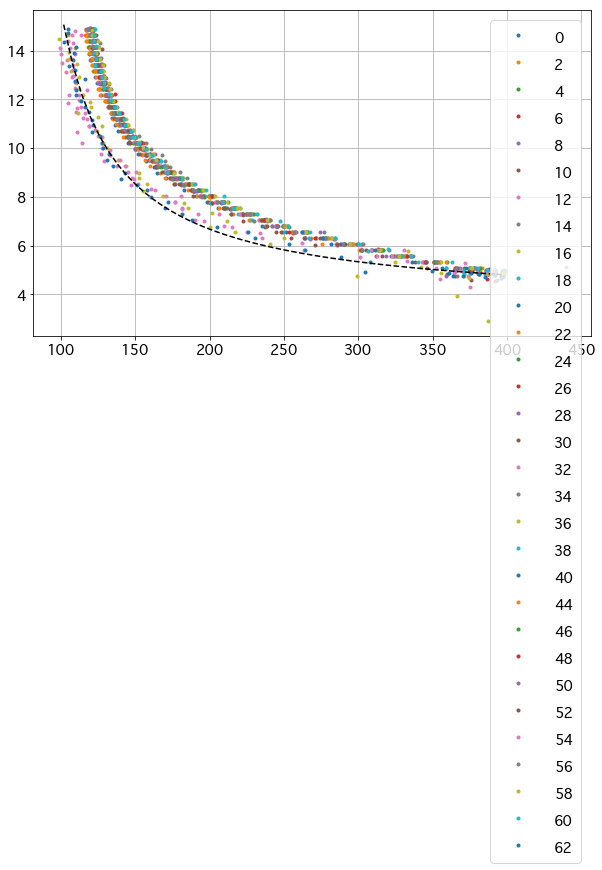

In [86]:
%%time
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 25
sel &= df_tot_join.rechit_energy > 20

#sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 2
df_sel = df_tot_join[sel]
chans = np.sort(df_sel.rechit_channel.unique())

## x = energy
# bins1 = np.logspace(np.log10(20),np.log10(200),100)
# #bins1 = np.linspace(20,800,150)
# xval = 'rechit_energy'

## x = LG
bins1 = np.logspace(np.log10(100),np.log10(400),100)
xval = 'rechit_amplitudeLow'

## y
bins2 = np.linspace(3,15,50)
yval = 'deltaT_ref'


for chan in chans:#[:5]:
    chan_sel = df_sel.rechit_channel == chan
    
    nhits = np.count_nonzero(chan_sel)
    print chan, nhits,
    
    #if nhits < 1000: continue

    x = df_sel[chan_sel][xval]
    y = (df_sel[chan_sel][yval] - df_sel[chan_sel].ref_offset + 4)%25
    
    x_mean, y_mean, y_err = stitched_tw_profile(x,y,bins1,bins2, 5)
    plt.plot(x_mean, y_mean, '.', label = str(chan))#, mfc = 'none')
    
    sel = y_mean > 3
    tw_params, pcov = curve_fit(tw_func, x_mean[sel], y_mean[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )
    
    print tw_params
    
tw_params = tw_params.tolist()
xs = np.linspace(x_mean.min(),x_mean.max())
plt.plot(xs,tw_func(xs,*tw_params), 'k--')
    
plt.legend()
plt.grid()

CPU times: user 4.36 s, sys: 573 ms, total: 4.93 s
Wall time: 7.72 s


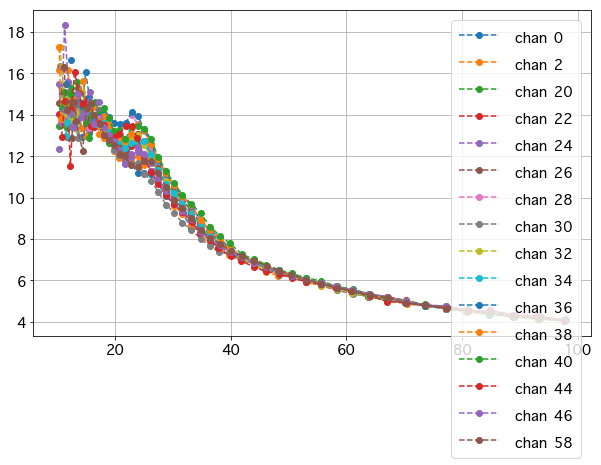

In [44]:
%%time
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 12.5
sel &= df_tot_join.rechit_energy > 10
sel &= df_tot_join.rechit_energy < 1700

#sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 2

#sel &= df_tot_join.ref_offset != 0

## x = energy
bins = np.logspace(np.log10(10),np.log10(100),50)
xval = 'rechit_energy'

## x = LG
# bins = np.logspace(np.log10(100),np.log10(2000),50)
# xval = 'rechit_amplitudeLow'

yval = 'deltaT_ref'

#chips = np.sort(df_tot_join[sel].rechit_chip_id.unique())
chans = np.sort(df_tot_join[sel].rechit_chan_id.unique())

for chan in chans:
    chan_sel = sel & (df_tot_join.rechit_chan_id == chan)
    
    nhits = np.count_nonzero(chan_sel)
    if nhits < 10000: continue
    #print nhits

    x = df_tot_join[chan_sel][xval]
    y = (df_tot_join[chan_sel][yval] - df_tot_join[chan_sel].ref_offset + 4)%25

    x_mean,y_mean = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
    
    plt.plot(x_mean, y_mean, 'o--', label = 'chan %i' %(df_tot_join.rechit_channel[chan_sel].iloc[0]))

plt.legend()
#plt.xscale('log')
plt.grid()

CPU times: user 602 ms, sys: 125 ms, total: 727 ms
Wall time: 767 ms


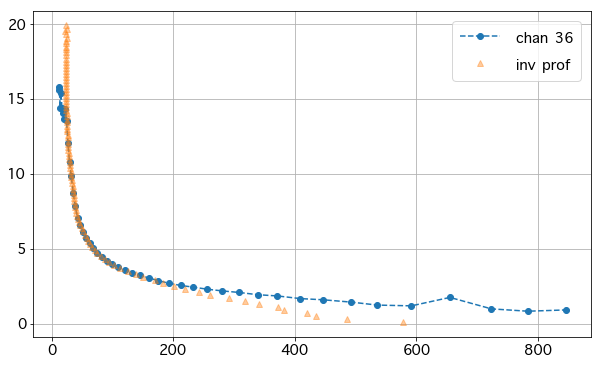

In [45]:
%%time
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 20
# sel = df_tot_join.deltaT_ref > -5
# sel = df_tot_join.deltaT_ref < 20

sel &= df_tot_join.rechit_energy > 10
sel &= df_tot_join.rechit_energy < 1700

sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 2

#sel &= df_tot_join.ref_offset != 0

## x = energy
bins = np.logspace(np.log10(10),np.log10(1000),50)
xval = 'rechit_energy'

## x = LG
# bins = np.logspace(np.log10(100),np.log10(2500),50)
# xval = 'rechit_amplitudeLow'

yval = 'deltaT_ref'

#chips = np.sort(df_tot_join[sel].rechit_chip_id.unique())
chans = np.sort(df_tot_join[sel].rechit_chan_id.unique())

for chan in chans[:1]:
    chan_sel = sel & (df_tot_join.rechit_chan_id == chan)
    
    nhits = np.count_nonzero(chan_sel)
    if nhits < 10000: continue
    #print nhits

    x = df_tot_join[chan_sel][xval]
    y = (df_tot_join[chan_sel][yval] - df_tot_join[chan_sel].ref_offset + 4)%25

    ## dt vs energy
    x_mean,y_mean = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
    plt.plot(x_mean, y_mean, 'o--', label = 'chan %i' %(df_tot_join.rechit_channel[chan_sel].iloc[0]))    
    
    ## evnergy vs dt profile
    y_mean,x_mean = binned_statistic(y, [y,x], bins=np.linspace(0,20,100), statistic='median').statistic
    plt.plot(x_mean, y_mean, '^', label = 'inv prof' , alpha = 0.4)

plt.legend()
#plt.xscale('log')
plt.grid()

In [46]:
sel = df_tot_join.rechit_layer == 8
sel &= df_tot_join.run > 380 
df_sel = df_tot_join[sel].copy()

df_sel['nhits'] = df_sel.groupby('event').size()

(array([0., 0., 0., 0., 0., 0., 0., 0., 0.]),
 array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 <a list of 9 Patch objects>)

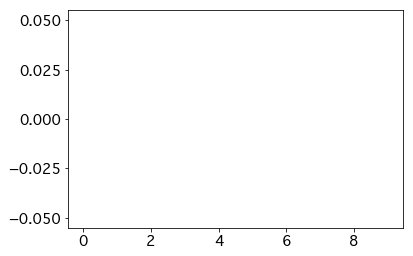

In [47]:
plt.hist(nhits, range(10))

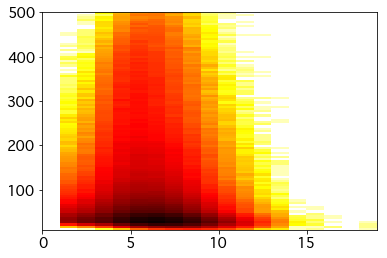

In [48]:
sel = df_sel.rechit_energy < 500
r = plt.hist2d(df_sel[sel].nhits, df_sel[sel].rechit_energy, (range(20),100), norm = LogNorm())

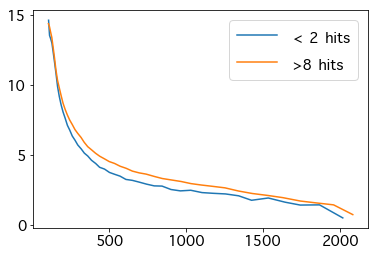

In [49]:
## x = energy
# bins = np.logspace(np.log10(10),np.log10(600),50)
# xval = 'rechit_energy'

## x = LG
bins = np.logspace(np.log10(100),np.log10(2500),50)
xval = 'rechit_amplitudeLow'
yval = 'deltaT_ref'


sel = df_sel.nhits < 2

x = df_sel[sel][xval]
y = (df_sel[sel][yval] - df_sel[sel].ref_offset + 4)%25

## dt vs energy
x_mean,y_mean = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
plt.plot(x_mean, y_mean, label = '< 2 hits')

sel = df_sel.nhits > 8

x = df_sel[sel][xval]
y = (df_sel[sel][yval] - df_sel[sel].ref_offset + 4)%25

## dt vs energy
x_mean,y_mean = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
plt.plot(x_mean, y_mean, label = '>8 hits')

#plt.xscale('log')
plt.legend()

### Vs Energy

In [50]:
%%time
sel = abs(df_tot_join.deltaT_ref) < 20
sel = df_tot_join.deltaT_ref > -5
sel = df_tot_join.deltaT_ref < 20
sel &= abs(df_tot_join.toa_rise_time - 6) < 4

sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 2

## x = energy
bins = np.logspace(np.log10(20),np.log10(800),150)
#bins = np.linspace(20,800,150)
xval = 'rechit_energy'

## x = LG
# bins = np.logspace(np.log10(100),np.log10(2000),100)
# xval = 'rechit_amplitudeLow'

yval = 'deltaT_ref'

x = df_tot_join[sel][xval]
y = (df_tot_join[sel][yval] - df_tot_join[sel].ref_offset + 4)%25

CPU times: user 227 ms, sys: 131 ms, total: 358 ms
Wall time: 393 ms


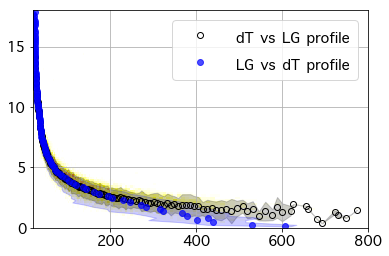

In [51]:
#plt.figure(figsize = (20,10))

### dt vs LG
x_mean1,y_mean1 = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
x_err1,y_err1 = binned_statistic(x, [x,y], bins=bins, statistic=iqr).statistic

plt.plot(x_mean1, y_mean1, 'ko', label = 'dT vs LG profile', mfc = 'none')
plt.fill_between(x_mean1, y_mean1 - y_err1, y_mean1 + y_err1, alpha = 0.2, color =  'k')


### LG vs dt
bins2 = np.linspace(0,18,100)
x_mean2,y_mean2 = binned_statistic(y, [x,y], bins=bins2, statistic='median').statistic
x_err2,y_err2 = binned_statistic(y, [x,y], bins=bins2, statistic=iqr).statistic

plt.plot(x_mean2, y_mean2, 'bo', alpha = 0.7, label = 'LG vs dT profile')
plt.fill_betweenx(y_mean2, x_mean2 - x_err2, x_mean2 + x_err2, alpha = 0.2, color = 'b')

plt.hist2d(x,y,(bins,bins2))

plt.grid()
plt.legend()
plt.show()

In [52]:
nan_idxs = np.isnan(x_mean1 * y_mean1 * y_err1)
x_mean1 = x_mean1[~nan_idxs]; y_mean1 = y_mean1[~nan_idxs]; y_err1 = y_err1[~nan_idxs]

sel1 = x_mean1 > 50; #sel1 &= x_mean1 < 300
sel1 &= y_mean1 > 0
sel1 &= y_mean1 < 15

nan_idxs = np.isnan(x_mean2 * y_mean2 * y_err2)
x_mean2 = x_mean2[~nan_idxs]; y_mean2 = y_mean2[~nan_idxs]; y_err2 = y_err2[~nan_idxs]

sel2 = x_mean2 < 100; #sel2 &= x_mean2 < 600
sel2 &= y_mean2 > 0
sel2 &= y_mean2 < 15

x_comb = np.append(x_mean1[sel1], x_mean2[sel2])
y_comb = np.append(y_mean1[sel1], y_mean2[sel2])

y_comb_err = np.append(y_err1[sel1], y_err2[sel2])

sort_idx = x_comb.argsort()
x_comb = x_comb[sort_idx]
y_comb = y_comb[sort_idx]
y_comb_err = y_comb_err[sort_idx]

In [53]:
# convert iqr to sigma
y_comb_err /=1.349

Fit params [7.022232030778103e-16, 2.5040518647996857, 143.1730187000553, 11.813841936573285]
Fit params [8.086065002588665e-18, 1.3176440400478195, 283.8816421634333, -8.674771299830576]
Fit params [6.5614557427266714e-24, 1.2116738197721608, 257.58975308266696, 1.1196055569745722]


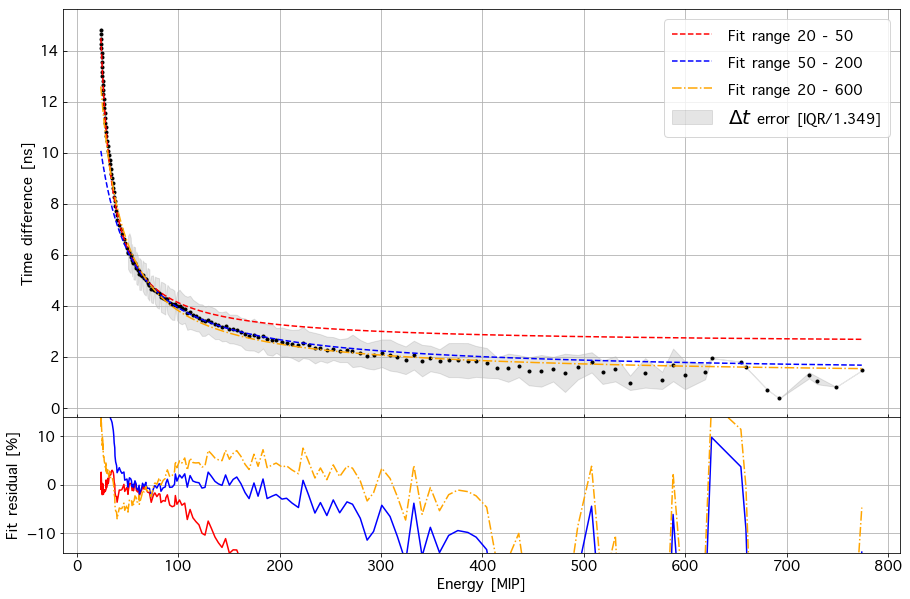

In [54]:
f, axs = plt.subplots(2, sharex=True, figsize = (15,10), gridspec_kw = {'height_ratios':[3,1]})

axs[0].plot(x_comb, y_comb, '.k')
axs[0].fill_between(x_comb, y_comb - y_comb_err, y_comb + y_comb_err,
                    alpha = 0.1, color = 'k', label = r'$\Delta t$ error [IQR/1.349]' )

# for func plotting
xs = np.linspace(min(x_comb),max(x_comb), 1000)

## fit range selection
min_x = 20; max_x = 50
sel = (y_comb < 15) & (y_comb > 0)
sel &= (x_comb > min_x) & (x_comb < max_x)

tw_params, pcov = curve_fit(tw_func, x_comb[sel], y_comb[sel],
                            sigma = 1/y_comb_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), 'r--',label = 'Fit range %i - %i' % (min_x, max_x))
axs[1].plot(x_comb,(y_comb - tw_func(x_comb,*tw_params))/y_comb*100., 'r')

print 'Fit params', tw_params

## fit range selection
min_x = 50; max_x = 200
sel = (y_comb < 15) & (y_comb > 0)
sel &= (x_comb > min_x) & (x_comb < max_x)

tw_params, pcov = curve_fit(tw_func, x_comb[sel], y_comb[sel],
                            sigma = 1/y_comb_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), 'b--',label = 'Fit range %i - %i' % (min_x, max_x))
axs[1].plot(x_comb,(y_comb - tw_func(x_comb,*tw_params))/y_comb*100., 'b')

print 'Fit params', tw_params

## fit range selection
min_x = 20; max_x = 600
sel = (y_comb < 15) & (y_comb > 0)
sel &= (x_comb > min_x) & (x_comb < max_x)

tw_params, pcov = curve_fit(tw_func, x_comb[sel], y_comb[sel],
                            sigma = 1/y_comb_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), '-.',color = 'orange',label = 'Fit range %i - %i' % (min_x, max_x))
axs[1].plot(x_comb,(y_comb - tw_func(x_comb,*tw_params))/y_comb*100., '-.',color = 'orange')

print 'Fit params', tw_params

### set up plot
f.subplots_adjust(hspace=0)

#axs[0].set_yscale('log'); axs[0].set_ylim(5,16)

axs[0].grid()
axs[0].legend()
axs[0].tick_params(direction = 'in')
axs[0].set_ylabel('Time difference [ns]')

#axs[0].set_xlim(120,300); axs[1].set_xlim(120,300)

axs[1].set_ylim(-14,14)
axs[1].grid()

axs[1].set_xlabel('Energy [MIP]')
axs[1].set_ylabel('Fit residual [%]')

## log x
# axs[0].set_xscale('log')#; axs[1].set_xscale('log')
# axs[0].set_xticks([30,50,100,200,400,600,800])
# axs[0].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


plt.show()

## vs LG

In [55]:
%%time
sel = abs(df_tot_join.deltaT_ref) < 20
sel = df_tot_join.deltaT_ref > -5
sel = df_tot_join.deltaT_ref < 20
sel &= abs(df_tot_join.toa_rise_time - 6) < 4

sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 2

## x = energy
# bins = np.logspace(np.log10(20),np.log10(500),100)
# xval = 'rechit_energy'

## x = LG
#bins = np.logspace(np.log10(100),np.log10(2000),100)
bins = np.linspace(100,1900,200)
xval = 'rechit_amplitudeLow'

yval = 'deltaT_ref'

x = df_tot_join[sel][xval]
y = (df_tot_join[sel][yval] - df_tot_join[sel].ref_offset + 4)%25

CPU times: user 216 ms, sys: 113 ms, total: 329 ms
Wall time: 314 ms


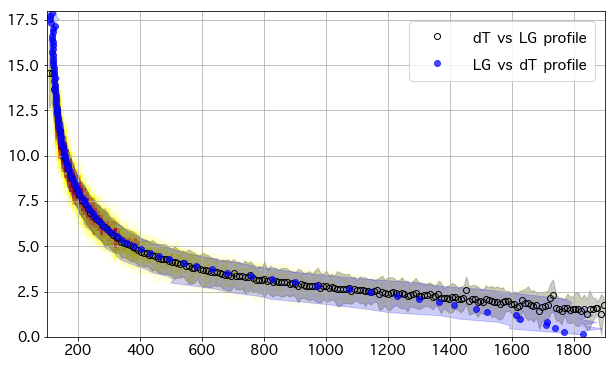

In [56]:
plt.figure(figsize = (10,6))

### dt vs LG
x_mean1,y_mean1 = binned_statistic(x, [x,y], bins=bins, statistic='mean').statistic
x_err1,y_err1 = binned_statistic(x, [x,y], bins=bins, statistic=iqr).statistic

plt.plot(x_mean1, y_mean1, 'ko', label = 'dT vs LG profile', mfc = 'none')
plt.fill_between(x_mean1, y_mean1 - y_err1, y_mean1 + y_err1, alpha = 0.2, color =  'k')


### LG vs dt
bins2 = np.linspace(0,18,100)
x_mean2,y_mean2 = binned_statistic(y, [x,y], bins=bins2, statistic='mean').statistic
x_err2,y_err2 = binned_statistic(y, [x,y], bins=bins2, statistic=iqr).statistic

plt.plot(x_mean2, y_mean2, 'bo', alpha = 0.7, label = 'LG vs dT profile')
plt.fill_betweenx(y_mean2, x_mean2 - x_err2, x_mean2 + x_err2, alpha = 0.2, color = 'b')

plt.hist2d(x,y,(bins,bins2))

plt.grid()
plt.legend()
plt.show()

In [57]:
## combine both profiles into single arrays
nan_idxs = np.isnan(x_mean1) & np.isnan(y_mean1) & np.isnan(y_err1)
x_mean1 = x_mean1[~nan_idxs]; y_mean1 = y_mean1[~nan_idxs]

sel1 = x_mean1 > 200; #sel1 &= x_mean1 < 300
sel1 &= y_mean1 > 0
sel1 &= y_mean1 < 15

nan_idxs = np.isnan(x_mean2) & np.isnan(y_mean2) & np.isnan(y_err2)
x_mean2 = x_mean2[~nan_idxs]; y_mean2 = y_mean2[~nan_idxs]

sel2 = x_mean2 < 300; #sel2 &= x_mean2 < 600
sel2 &= y_mean2 > 0
sel2 &= y_mean2 < 15

x_comb = np.append(x_mean1[sel1], x_mean2[sel2])
y_comb = np.append(y_mean1[sel1], y_mean2[sel2])

y_comb_err = np.append(y_err1[sel1], y_err2[sel2])

sort_idx = x_comb.argsort()
x_comb = x_comb[sort_idx]
y_comb = y_comb[sort_idx]
y_comb_err = y_comb_err[sort_idx]

In [58]:
# convert iqr to sigma
y_comb_err /=1.349

Fit params [1.3645982375059488e-17, 3.3105541455496166, 622.0497457487012, 65.59138354093095]
Fit params [1.1373421934419919e-15, 1.3567217563682006, 1474.0200701169977, -29.798588242381452]
Fit params [1.5024480371720012e-22, 1.534671795653792, 1234.9763679621558, 12.663342708703738]


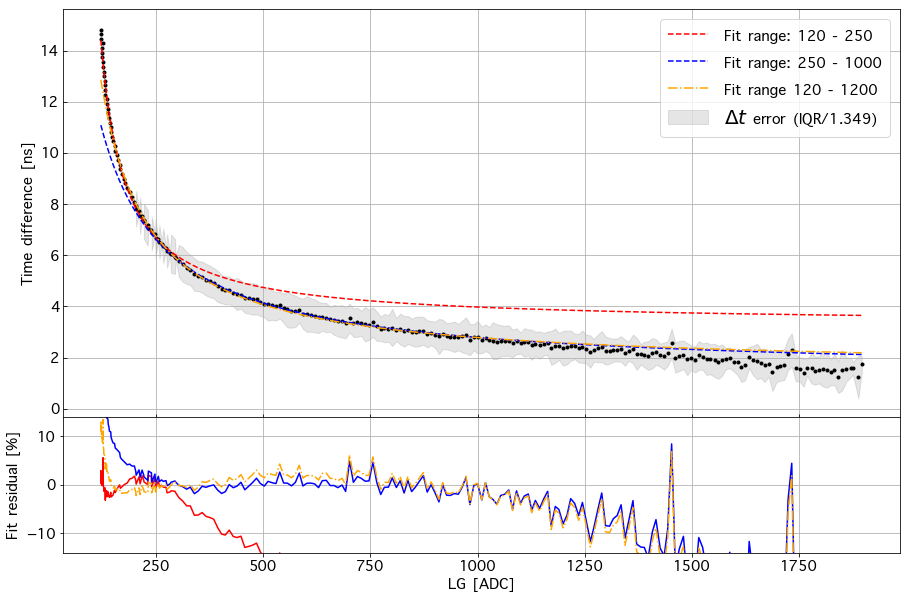

In [59]:
f, axs = plt.subplots(2, sharex=True, figsize = (15,10), gridspec_kw = {'height_ratios':[3,1]})

axs[0].plot(x_comb, y_comb, 'k.')
axs[0].fill_between(x_comb, y_comb - y_comb_err, y_comb + y_comb_err,
                    alpha = 0.1, color = 'k', label = r'$\Delta t$ error (IQR/1.349)' )

# for func plotting
xs = np.linspace(min(x_comb),max(x_comb), 1000)

## fit range selection
min_x = 120; max_x = 250
sel = (y_comb < 15) & (y_comb > 0)
sel &= (x_comb > min_x) & (x_comb < max_x)

tw_params, pcov = curve_fit(tw_func, x_comb[sel], y_comb[sel],
                            sigma = 1/y_comb_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), 'r--',label = 'Fit range: %i - %i' % (min_x, max_x))
axs[1].plot(x_comb,(y_comb - tw_func(x_comb,*tw_params))/y_comb*100., 'r')

print 'Fit params', tw_params

## fit range selection
min_x = 250; max_x = 1000
sel = (y_comb < 15) & (y_comb > 0)
sel &= (x_comb > min_x) & (x_comb < max_x)

tw_params, pcov = curve_fit(tw_func, x_comb[sel], y_comb[sel],
                            sigma = 1/y_comb_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), 'b--',label = 'Fit range: %i - %i' % (min_x, max_x))
axs[1].plot(x_comb,(y_comb - tw_func(x_comb,*tw_params))/y_comb*100., 'b')


print 'Fit params', tw_params

## fit range selection
min_x = 120; max_x = 1200
sel = (y_comb < 15) & (y_comb > 0)
sel &= (x_comb > min_x) & (x_comb < max_x)

tw_params, pcov = curve_fit(tw_func, x_comb[sel], y_comb[sel],
                            sigma = 1/y_comb_err[sel],
                            p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

tw_params = tw_params.tolist()
axs[0].plot(xs,tw_func(xs,*tw_params), '-.',color = 'orange',label = 'Fit range %i - %i' % (min_x, max_x))
axs[1].plot(x_comb,(y_comb - tw_func(x_comb,*tw_params))/y_comb*100., '-.',color = 'orange')

print 'Fit params', tw_params

### set up plot
f.subplots_adjust(hspace=0)

#axs[0].set_yscale('log'); axs[0].set_ylim(5,16)

axs[0].grid()
axs[0].legend()
axs[0].tick_params(direction = 'in')
axs[0].set_ylabel('Time difference [ns]')

#axs[0].set_xlim(120,300); axs[1].set_xlim(120,300)

axs[1].set_ylim(-14,14)
axs[1].grid()

axs[1].set_xlabel('LG [ADC]')
axs[1].set_ylabel('Fit residual [%]')

## log x
# axs[0].set_xscale('log')#; axs[1].set_xscale('log')
# axs[0].set_xticks([120,150,200,500,1000,1500])
# axs[0].get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.show()

In [60]:
(df_tot_join[chan_sel].rechit_amplitudeLow / df_tot_join[chan_sel].rechit_energy).median()

5.506577491760254

CPU times: user 3.58 s, sys: 525 ms, total: 4.11 s
Wall time: 4.46 s


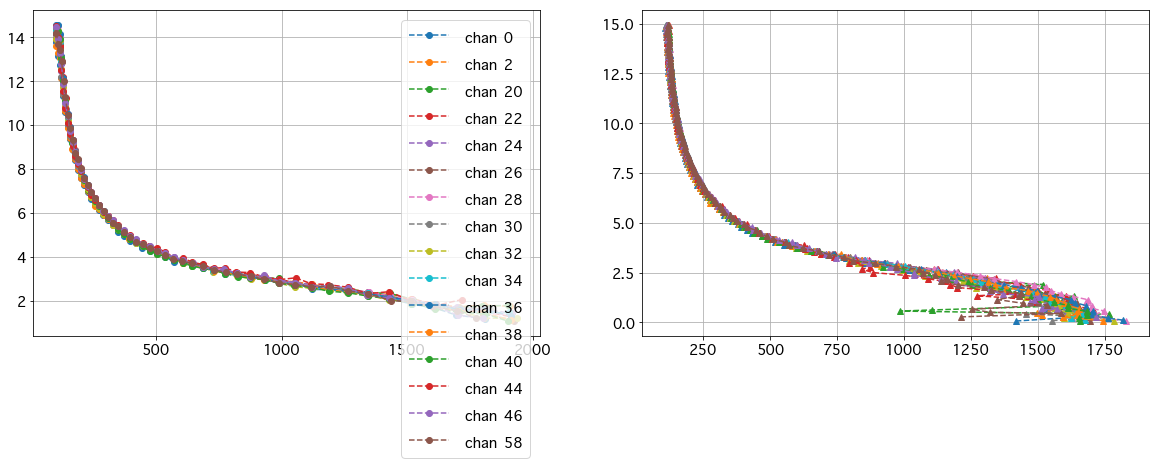

In [61]:
%%time
plt.figure(figsize = (20,6))

ax1 = plt.subplot(121)
ax2 = plt.subplot(122)

sel = abs(df_tot_join.deltaT_ref) < 12.5
sel &= df_tot_join.rechit_energy > 10
sel &= df_tot_join.rechit_energy < 1700

#sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
sel &= df_tot_join.rechit_chip_id%4 == 2

## x = energy
# bins = np.logspace(np.log10(10),np.log10(100),50)
# xval = 'rechit_energy'

## x = LG
bins = np.logspace(np.log10(100),np.log10(2000),50)
xval = 'rechit_amplitudeLow'

yval = 'deltaT_ref'

#chips = np.sort(df_tot_join[sel].rechit_chip_id.unique())
chans = np.sort(df_tot_join[sel].rechit_chan_id.unique())

for chan in chans:
    chan_sel = sel & (df_tot_join.rechit_chan_id == chan)
    
    nhits = np.count_nonzero(chan_sel)
    if nhits < 10000: continue
    #print nhits

    x = df_tot_join[chan_sel][xval]
    y = (df_tot_join[chan_sel][yval] - df_tot_join[chan_sel].ref_offset + 4)%25

    ## dt vs energy
    x_mean,y_mean = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
    ax1.plot(x_mean, y_mean, 'o--', label = 'chan %i' %(df_tot_join.rechit_channel[chan_sel].iloc[0]))    
    
    ## evnergy vs dt profile
    y_mean,x_mean = binned_statistic(y, [y,x], bins=np.linspace(0,15,100), statistic='median').statistic
    ax2.plot(x_mean, y_mean, '^--', label = 'chan %i' %(df_tot_join.rechit_channel[chan_sel].iloc[0]))
    

ax1.legend()
#plt.xscale('log')
ax1.grid()
ax2.grid()

Fit params [2.5644250413218933e-18, 0.551640919199995, 405.3328289422048, -15.45951351591114]
Fit params [4.5263825302429127e-20, 0.4693837162075212, 453.33463004464875, -27.796973262391806]
Fit params [1.4082417805021335e-19, 0.6131409910214825, 469.5366625309074, -37.51665687608306]
Fit params [5.633551362527859e-20, 0.4878864563685014, 491.1778095372163, -37.57304396899123]
CPU times: user 3.45 s, sys: 500 ms, total: 3.95 s
Wall time: 4.79 s


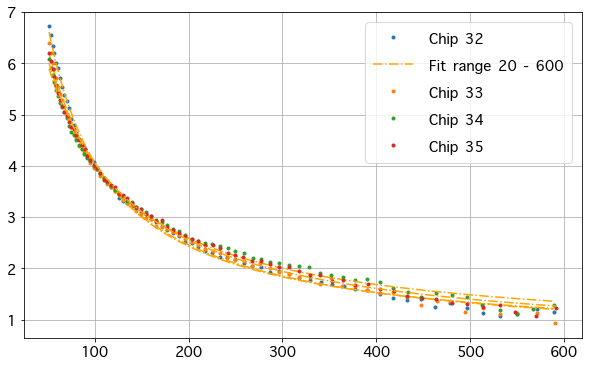

In [62]:
%%time
plt.figure(figsize = (10,6))

sel = abs(df_tot_join.deltaT_ref) < 20
sel = df_tot_join.deltaT_ref > -5
sel = df_tot_join.deltaT_ref < 20
sel &= abs(df_tot_join.toa_rise_time - 6) < 4

#sel &= df_tot_join.rechit_channel == 36
sel &= df_tot_join.rechit_layer == 8
#sel &= df_tot_join.rechit_chip_id%4 == 2

## x = energy
bins = np.logspace(np.log10(20),np.log10(600),100)
#bins = np.linspace(20,800,150)
xval = 'rechit_energy'

## x = LG
# bins = np.logspace(np.log10(100),np.log10(2000),100)
# xval = 'rechit_amplitudeLow'

yval = 'deltaT_ref'

x = df_tot_join[sel][xval]
y = (df_tot_join[sel][yval] - df_tot_join[sel].ref_offset + 4)%25


chips = np.sort(df_tot_join[sel].rechit_chip_id.unique())

for chip in chips:
    chan_sel = sel & (df_tot_join.rechit_chip_id == chip)

    x = df_tot_join[chan_sel][xval]
    y = (df_tot_join[chan_sel][yval] - df_tot_join[chan_sel].ref_offset + 4)%25
    
    ### dt vs LG
    x_mean1,y_mean1 = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
    x_err1,y_err1 = binned_statistic(x, [x,y], bins=bins, statistic=iqr).statistic

    #plt.plot(x_mean1, y_mean1, 'o', label = 'Chip %i' %(chip))
    #plt.fill_between(x_mean1, y_mean1 - y_err1, y_mean1 + y_err1, alpha = 0.2, color =  'k')


    ### LG vs dt
    bins2 = np.linspace(0,18,100)
    #x_mean2,y_mean2 = binned_statistic(y, [x,y], bins=bins2, statistic='mean').statistic
    #x_err2,y_err2 = binned_statistic(y, [x,y], bins=bins2, statistic=iqr).statistic

    
    ## Combine data points
    nan_idxs = np.isnan(x_mean1 * y_mean1 * y_err1)
    x_mean1 = x_mean1[~nan_idxs]; y_mean1 = y_mean1[~nan_idxs]; y_err1 = y_err1[~nan_idxs]

    sel1 = x_mean1 > 50; #sel1 &= x_mean1 < 300
    sel1 &= y_mean1 > 0
    sel1 &= y_mean1 < 15

    nan_idxs = np.isnan(x_mean2 * y_mean2 * y_err2)
    x_mean2 = x_mean2[~nan_idxs]; y_mean2 = y_mean2[~nan_idxs]; y_err2 = y_err2[~nan_idxs]

    sel2 = x_mean2 < 100; #sel2 &= x_mean2 < 600
    sel2 &= y_mean2 > 0
    sel2 &= y_mean2 < 15

    x_comb = np.append(x_mean1[sel1], x_mean2[sel2])
    y_comb = np.append(y_mean1[sel1], y_mean2[sel2])

    y_comb_err = np.append(y_err1[sel1], y_err2[sel2])

    sort_idx = x_comb.argsort()
    x_comb = x_comb[sort_idx]
    y_comb = y_comb[sort_idx]
    y_comb_err = y_comb_err[sort_idx]
    
    # convert iqr to sigma
    y_comb_err /=1.349
    
    plt.plot(x_comb, y_comb, '.',  label = 'Chip %i' %(chip))
    
    ## fit range selection
    min_x = 20; max_x = 600
    #sel = (y_comb < 15)# & (y_comb > 0)
    #sel = (x_comb > min_x) & (x_comb < max_x)

    tw_params, pcov = curve_fit(tw_func, x_comb, y_comb,
                                sigma = 1/y_comb_err,
                                p0 = [ 0, 0,  1e+03,  0], bounds=([0,-20,10,-1e3], [0.1, 20., 1e4, 1e3]) )

    tw_params = tw_params.tolist()
    
    xs = np.linspace(min(x_comb),max(x_comb), 1000)

    plt.plot(xs,tw_func(xs,*tw_params), '-.',color = 'orange',label = 'Fit range %i - %i' % (min_x, max_x))
    #axs[1].plot(x_comb,(y_comb - tw_func(x_comb,*tw_params))/y_comb*100., '-.',color = 'orange')

    print 'Fit params', tw_params


plt.legend()
plt.grid()

In [63]:
tw_params = [7.1637896372901985e-25, 0.8499666270628335, 310.6501777092844, -3.069704644898795]

In [64]:
%%time
df_tot_join['tw_corr'] = 0
df_tot_join['tw_corr'] = df_tot_join['rechit_energy'].apply(lambda x: tw_func(x, *tw_params))

# df['tw_corr_ch2'] = 0
# df_join['tw_corr_ch2'] = df_join['rechit_energy_ch2'].apply(lambda x: tw_func(x, *tw_params))

CPU times: user 4.04 s, sys: 558 ms, total: 4.59 s
Wall time: 4.7 s


In [65]:
%%time
df['tw_corr'] = 0
df['tw_corr'] = df['rechit_energy'].apply(lambda x: tw_func(x, *tw_params))

# df['tw_corr_ch2'] = 0
# df_join['tw_corr_ch2'] = df_join['rechit_energy_ch2'].apply(lambda x: tw_func(x, *tw_params))

CPU times: user 7.06 s, sys: 1.53 s, total: 8.6 s
Wall time: 10.2 s


## Select Si channels

## Load Si channels

In [66]:
# %%time

# fig = plt.figure(figsize = (10,6))

# min_chip = df.rechit_chip_id.min()
# max_chip = df.rechit_chip_id.max()

# plt.hist2d(df.rechit_chip_id,df.rechit_channel, bins = (range(min_chip,max_chip+2),64))

# plt.xticks(xrange(min_chip,max_chip+1))
# plt.yticks(xrange(0,64,8))

# plt.grid()
# plt.colorbar()
# plt.show()

In [67]:
df_test = df.iloc[:10000].copy()

In [68]:
df_sub = df_tot_join[['rechit_chan_id','rechit_energy']]

In [69]:
nhits = df_tot_join.groupby('rechit_chan_id').size()

In [70]:
chans = nhits[nhits > nhits.max() * 0.7].index.values

In [71]:
len(chans)

13

In [72]:
# for chan_id_1 in chans:
#     sel = df_sub.rechit_chan_id == chan_id_1

#     for chan_id_2 in chans:
#         if chan_id_2 == chan_id_1: continue

#         sel &= df_sub.rechit_chan_id == chan_id_2
#         print np.count_nonzero(sel)

In [73]:
dfs = {}

for chan_id in chans:
    sel = df_sub.rechit_chan_id == chan_id

    chan = chan_id%64  
    chip_id = (chan_id - chan)/64
    chip = chip_id%4
    layer = chip_id//4
    
    print chan_id, chan, chip_id, chip, layer
    
    dfs['E %i/%i/%i' %(layer, chip, chan)] = df_sub[sel]['rechit_energy']

1892 36.0 29.0 1.0 7.0
1956 36.0 30.0 2.0 7.0
1958 38.0 30.0 2.0 7.0
1960 40.0 30.0 2.0 7.0
2212 36.0 34.0 2.0 8.0
2214 38.0 34.0 2.0 8.0
2276 36.0 35.0 3.0 8.0
2328 24.0 36.0 0.0 9.0
2404 36.0 37.0 1.0 9.0
2412 44.0 37.0 1.0 9.0
2468 36.0 38.0 2.0 9.0
2470 38.0 38.0 2.0 9.0
2532 36.0 39.0 3.0 9.0


In [74]:
df_enes = pd.DataFrame(dfs)

In [75]:
corr = df_enes.corr()
#corr

In [76]:
# f, ax = plt.subplots(figsize = (10,7))

# ax.matshow(corr)
# #plt.colorbar(ax)

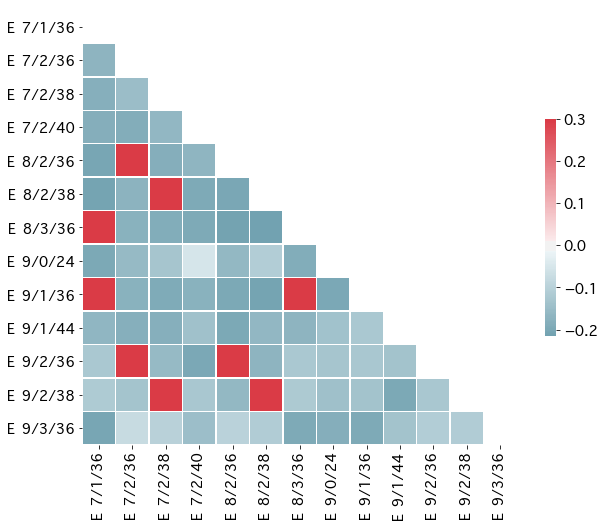

In [77]:
# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(10, 8))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

In [78]:
%%time
nhits = df_tot_join.groupby(['rechit_chip_id','rechit_channel']).size()
print nhits.sort_values(ascending = False)[:10]

rechit_chip_id  rechit_channel
30              36                143767
38              36                138160
30              38                135141
38              38                131557
37              36                127444
34              36                126355
                38                116720
37              44                114226
35              36                111951
29              36                111448
dtype: int64
CPU times: user 406 ms, sys: 214 ms, total: 621 ms
Wall time: 629 ms


In [79]:
%%time
nhits = df.groupby(['rechit_chip_id','rechit_channel']).size()
print nhits.sort_values(ascending = False)[:10]

rechit_chip_id  rechit_channel
30              36                254060
38              36                242440
34              36                225830
30              38                223555
38              38                215029
37              36                203769
34              38                191842
37              44                188392
39              36                185385
35              36                182420
dtype: int64
CPU times: user 1.3 s, sys: 1.43 s, total: 2.72 s
Wall time: 4.05 s


In [80]:
%%time
layer = 7
chip1 = 4*layer + 2
chan1 = 36

layer = 8
chip2 = 4*layer + 2
chan2 = 36

sel = df.rechit_energy > 20
sel &= df.toa_rise_time > 0
sel &= df.rechit_chip_id == chip1
df_ch1 = df[sel & (df.rechit_channel == chan1)].copy()

sel = df.rechit_energy > 20
sel &= df.toa_rise_time > 0
sel &= df.rechit_chip_id == chip2
df_ch2 = df[sel & (df.rechit_channel == chan2)].copy()

df_join = df_ch1.join(df_ch2, lsuffix='_ch1', rsuffix='_ch2')

# sel = (df_join.rechit_energy_ch1 > 0) & (df_join.rechit_energy_ch2 > 0)
# df_join = df_join[sel]
#df_join.dropna(inplace = True)

print len(df_join), ' entries'

253381  entries
CPU times: user 1.08 s, sys: 3.47 s, total: 4.55 s
Wall time: 7.57 s


In [81]:
sel = df_join.rechit_energy_ch1 > 10
sel &= df_join.rechit_energy_ch2 > 10

np.count_nonzero(sel)

198366

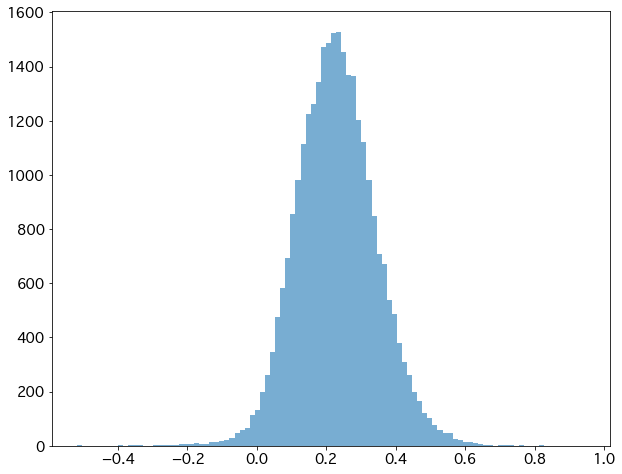

0.11075497809289053

In [82]:
fig = plt.figure(figsize = (10,8))

#dt = (df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1  - df_join.deltaT_ref_ch1) - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2 - df_join.deltaT_ref_ch2)
dt = (df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1) - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)
#dt = (df_join.toa_rise_time_ch1) - (df_join.toa_rise_time_ch2)

sel = abs(dt) < 2
sel &= df_join.rechit_energy_ch1 > 200
sel &= df_join.rechit_energy_ch2 > 200


plt.hist(dt[sel],100, alpha = 0.6)
plt.show()

iqr(dt[sel])/1.35

In [83]:
# fig = plt.figure(figsize = (10,8))

# dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)

# sel = abs(dt-dt.mean()) < 0.7
# sel &= df_join.rechit_energy_ch2 > 100

# plt.hist2d(df_join[sel].rechit_energy_ch1, dt[sel],100)
# plt.show()

In [87]:
def tres_func(x, a):

    return a / x

def tres_func_2(x, a, b):

    return np.sqrt((a / x)**2 + b**2)

def tres_func_3(x, a, b, c):

    return np.sqrt((a / (x-b))**2 + c**2)

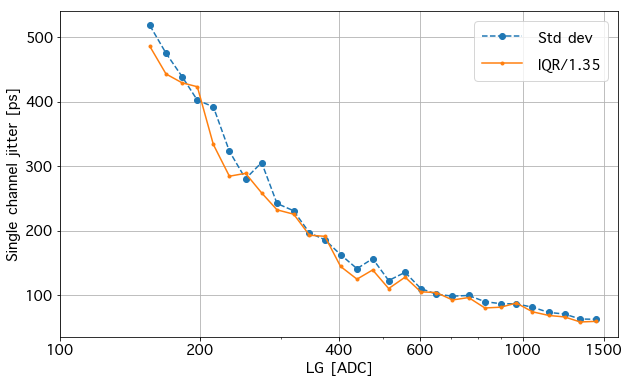

In [85]:
dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)
#dt = df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2

sel = abs(dt) < 2

sel &= df_join.rechit_toaFall_norm_ch1 < 0.75
sel &= df_join.rechit_toaFall_norm_ch2 < 0.75

sel &= df_join.rechit_amplitudeLow_ch2 > 100
sel &= abs(df_join.rechit_amplitudeLow_ch1 - df_join.rechit_amplitudeLow_ch2)/df_join.rechit_amplitudeLow_ch2 < 0.05

y = dt[sel]
x = df_join[sel].rechit_amplitudeLow_ch1

plt.figure(figsize = (10,6))

#bins = np.linspace(0,800,50)
bins = np.logspace(np.log10(150),np.log10(1500),30)

x_mean,y_mean = binned_statistic(x, [x,y], bins=bins, statistic='mean').statistic
x_err,y_err = binned_statistic(x, [x,y], bins=bins, statistic='std').statistic
x_err_iqr,y_err_iqr = binned_statistic(x, [x,y], bins=bins, statistic=iqr).statistic

y_err /= np.sqrt(2) / 1000.
y_err_iqr /= np.sqrt(2) / 1000.

plt.plot(x_mean, y_err, 'o--', label = 'Std dev')
plt.plot(x_mean, y_err_iqr/1.35, '.-', label = 'IQR/1.35')

plt.xlabel('LG [ADC]')
plt.ylabel('Single channel jitter [ps]')

plt.xscale('log')
plt.xticks([100,200,400,600, 1000, 1500])
plt.gca().get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

#plt.yscale('log')
# plt.ylim(30,300)

plt.legend()
plt.grid()

In [88]:
nan_idxs = np.isnan(x_mean * y_mean * y_err)
x_mean = x_mean[~nan_idxs]; y_mean = y_mean[~nan_idxs]; y_err = y_err[~nan_idxs]

sel = x_mean > 50
sel = x_mean < 750

tres_params, pcov = curve_fit(tres_func, x_mean[sel], y_err[sel])
print tres_params

tres_params_3, pcov = curve_fit(tres_func_3, x_mean[sel], y_err[sel], p0 = [77000, 50,0])
print tres_params_3

[77145.1058012]
[6.49483134e+04 3.38816973e+01 0.00000000e+00]


/usr/local/lib/python2.7/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


In [89]:
slope = 77198 # ps/LG-ADC
slope *= 5 # ps/MIP
slope /= 3.5 # ps/fC
slope /= 1000 # ns/fC

slope

110.28285714285714

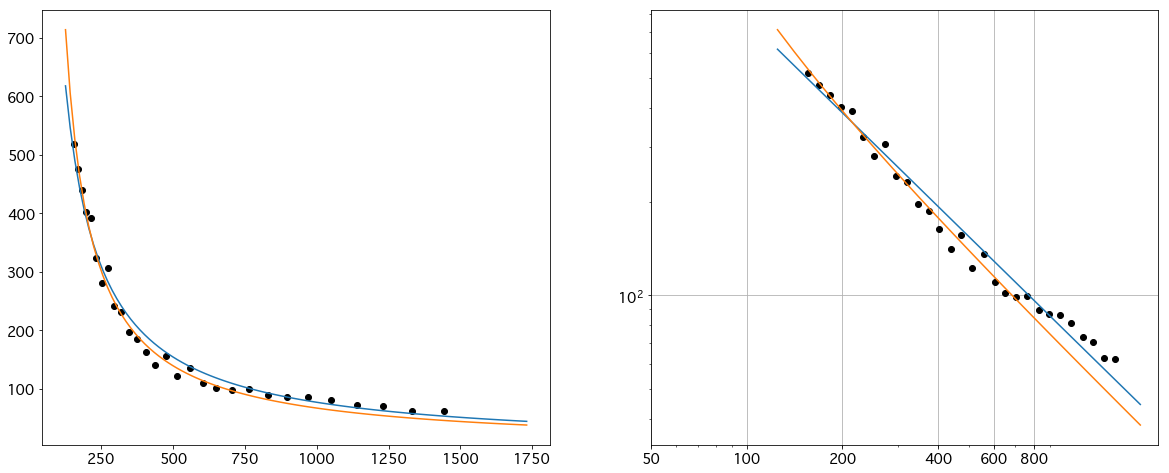

In [90]:
plt.figure(figsize = (20,8))

xs = np.linspace(x_mean.min()*0.8, x_mean.max()*1.2,100)

plt.subplot(121)
plt.plot(x_mean, y_err, 'ko', label = 'Std dev')
plt.plot(xs, tres_func(xs, *tres_params), label = 'Fit no sigma_floor')
plt.plot(xs, tres_func_3(xs, *tres_params_3), label = 'Fit with sigma_floor')


plt.subplot(122)
plt.plot(x_mean, y_err, 'ko', label = 'Std dev')
plt.plot(xs, tres_func(xs, *tres_params), label = 'Fit no sigma_floor')
plt.plot(xs, tres_func_3(xs, *tres_params_3), label = 'Fit with sigma_floor')

plt.xscale('log')
plt.xticks([50, 100,200,400,600,800])
plt.gca().get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.yscale('log')
#plt.ylim(50,500)

plt.grid()

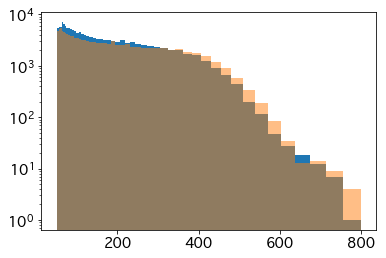

In [91]:
sel = df_join.rechit_energy_ch1 > 10
sel &= df_join.rechit_energy_ch2 > 10

#bins = np.linspace(0,800,25)
bins = np.logspace(np.log10(50),np.log10(800),50)

plt.hist(df_join.rechit_energy_ch1[sel], bins,)
plt.hist(df_join.rechit_energy_ch2[sel], bins, alpha = 0.5)

plt.yscale('log')

plt.show()

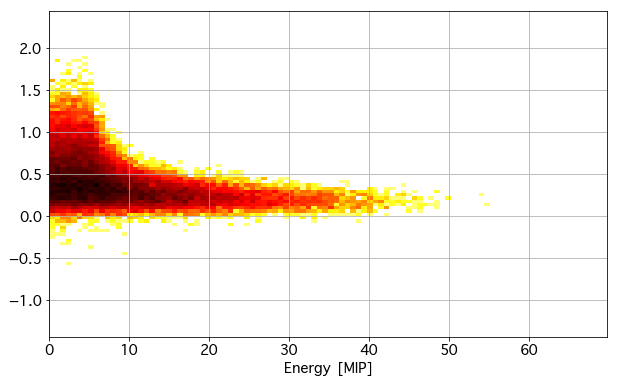

In [92]:
dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)
#dt = df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2

sel = abs(dt) < 3

# sel &= df_join.rechit_toaFall_norm_ch1 < 0.75
# sel &= df_join.rechit_toaFall_norm_ch2 < 0.75

sel &= df_join.rechit_energy_ch2 > 50
sel &= abs(df_join.rechit_energy_ch1 - df_join.rechit_energy_ch2)/df_join.rechit_energy_ch2 < 0.1

y = dt[sel]
#x = df_join[sel].rechit_energy_ch1
x = abs(df_join[sel].rechit_energy_ch1 - df_join[sel].rechit_energy_ch2)

plt.figure(figsize = (10,6))

bins = np.linspace(1,np.log(800),50)
#bins = np.logspace(np.log10(50),np.log10(700),20)

plt.hist2d(x,y,(100,100), norm = LogNorm())

plt.xlabel('Energy [MIP]')
#plt.ylabel('Single channel jitter [ps]')

#plt.xscale('log')
# plt.xticks([50, 100,200,400,600,800])
# plt.gca().get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# plt.yscale('log')
# plt.ylim(30,300)

#plt.legend()
plt.grid()

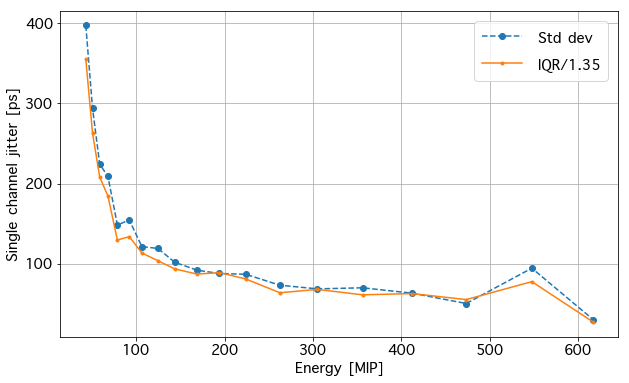

In [93]:
dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)
#dt = df_join.toa_rise_time_ch1 - df_join.toa_rise_time_ch2

sel = abs(dt) < 5

# sel &= df_join.rechit_toaFall_norm_ch1 < 0.75
# sel &= df_join.rechit_toaFall_norm_ch2 < 0.75

sel &= df_join.rechit_energy_ch2 > 20
sel &= abs(df_join.rechit_energy_ch1 - df_join.rechit_energy_ch2)/df_join.rechit_energy_ch2 < 0.01

y = dt[sel]
x = df_join[sel].rechit_energy_ch1

plt.figure(figsize = (10,6))

#bins = np.linspace(0,800,25)
bins = np.logspace(np.log10(40),np.log10(700),20)

x_mean,y_mean = binned_statistic(x, [x,y], bins=bins, statistic='median').statistic
#x_mean = (bins[1:] + bins[:-1])/2

x_err,y_err = binned_statistic(x, [x,y], bins=bins, statistic='std').statistic
x_err_iqr,y_err_iqr = binned_statistic(x, [x,y], bins=bins, statistic=iqr).statistic

y_err /= np.sqrt(2) / 1000.
y_err_iqr /= 1.35 * np.sqrt(2) / 1000.

plt.plot(x_mean, y_err, 'o--', label = 'Std dev')
plt.plot(x_mean, y_err_iqr, '.-', label = 'IQR/1.35')

plt.xlabel('Energy [MIP]')
plt.ylabel('Single channel jitter [ps]')

# plt.xscale('log')
# plt.xticks([50, 100,200,400,600,800])
# plt.gca().get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

# plt.yscale('log')
# plt.ylim(30,300)

plt.legend()
plt.grid()

In [94]:
y_err = y_err_iqr

In [95]:
nan_idxs = np.isnan(x_mean * y_mean * y_err)
x_mean = x_mean[~nan_idxs]; y_mean = y_mean[~nan_idxs]; y_err = y_err[~nan_idxs]

sel = x_mean > 50
sel &= y_err > 0
#sel &= y_err > 80
#sel &= y_err > 0
#sel &= x_mean < 80

tres_params, pcov = curve_fit(tres_func, x_mean[sel], y_err[sel])
print tres_params

tres_params_2, pcov = curve_fit(tres_func_2, x_mean[sel], y_err[sel])
print tres_params_2

tres_params_3, pcov = curve_fit(tres_func_3, x_mean[sel], y_err[sel], p0 = [15000,10,50])
print tres_params_3

[12936.19076944]
[11876.17516865    50.493857  ]
[8986.07615624   14.72026793   57.55424006]


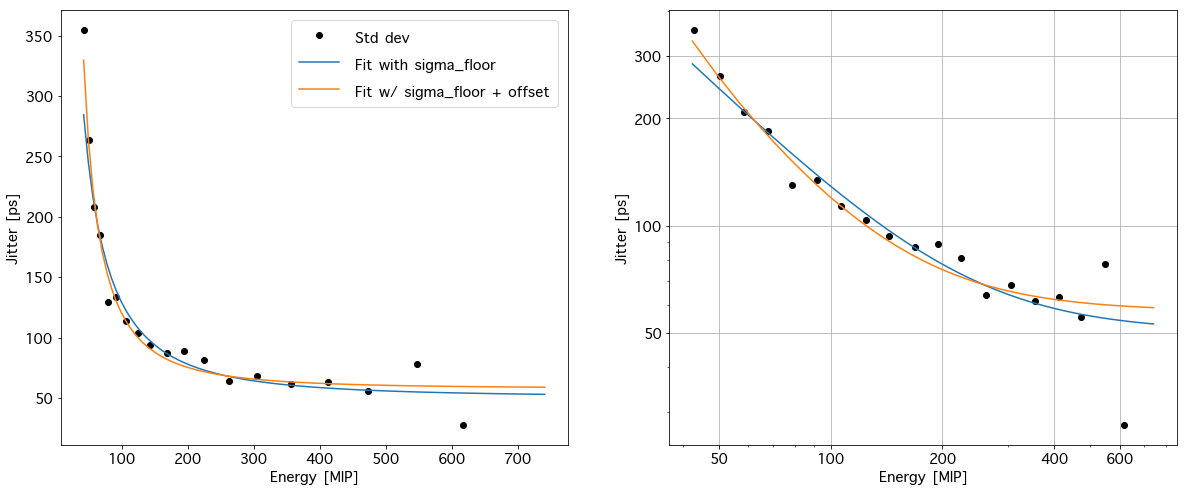

In [96]:
plt.figure(figsize = (20,8))

xs = np.linspace(x_mean.min()*0.99, x_mean.max()*1.2,100)

plt.subplot(121)
plt.plot(x_mean, y_err, 'ko', label = 'Std dev')
# plt.plot(xs, tres_func(xs, *tres_params), label = 'Fit no sigma_floor')
plt.plot(xs, tres_func_2(xs, *tres_params_2), label = 'Fit with sigma_floor')
plt.plot(xs, tres_func_3(xs, *tres_params_3), label = 'Fit w/ sigma_floor + offset')


plt.xlabel('Energy [MIP]')
plt.ylabel('Jitter [ps]')

plt.legend()

plt.subplot(122)
plt.plot(x_mean, y_err, 'ko', label = 'Std dev')
# plt.plot(xs, tres_func(xs, *tres_params), label = 'Fit no sigma_floor')
plt.plot(xs, tres_func_2(xs, *tres_params_2), label = 'Fit with sigma_floor')
plt.plot(xs, tres_func_3(xs, *tres_params_3), label = 'Fit w/ sigma_floor + offset')

plt.xlabel('Energy [MIP]')
plt.ylabel('Jitter [ps]')

plt.xscale('log')
plt.xticks([50, 100,200,400,600])
plt.gca().get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.yscale('log')
#plt.ylim(40,500)

plt.yticks([50,100,200,300])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())


plt.grid()

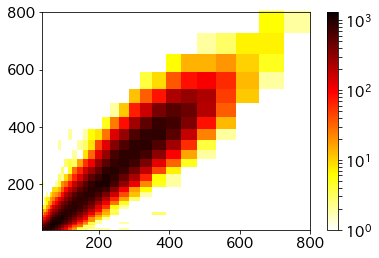

In [97]:
dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)

sel = abs(dt) < 2
#sel &= df_join.rechit_energy_ch2 > 30
sel &= df_join.rechit_toaFall_norm_ch1 < 10
sel &= df_join.rechit_toaFall_norm_ch2 < 10

x1 = df_join[sel].rechit_energy_ch1
x2 = df_join[sel].rechit_energy_ch2

bins = np.logspace(np.log10(40),np.log10(800),30)

plt.hist2d(x1,x2,bins, norm = LogNorm())

plt.colorbar()
plt.show()

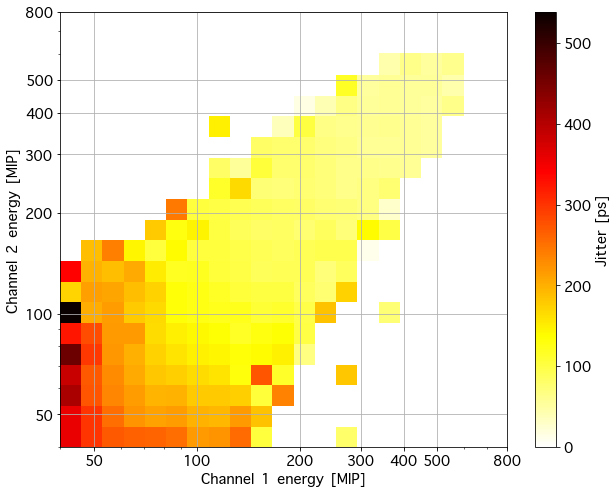

In [98]:
dt = df_join.toa_rise_time_ch1 - df_join.tw_corr_ch1 - (df_join.toa_rise_time_ch2 - df_join.tw_corr_ch2)

sel = abs(dt) < 3
#sel &= df_join.rechit_energy_ch2 > 30
sel &= df_join.rechit_toaFall_norm_ch1 < .65
sel &= df_join.rechit_toaFall_norm_ch2 < .65

y = dt[sel]
x1 = df_join[sel].rechit_energy_ch1
x2 = df_join[sel].rechit_energy_ch2

bins = np.logspace(np.log10(40),np.log10(600),20)
#bins = np.linspace(15,700,30)

ret = binned_statistic_2d(x1, x2, y, bins=bins, statistic='std')#.statistic

counts, xedges, yedges, binnumber = ret

counts /= np.sqrt(2) / 1000 # *1.35
#counts[counts > 300] = 0
#counts[abs(counts) > 1] = 0

XX, YY = np.meshgrid(xedges, yedges)

fig = plt.figure(figsize = (10,8))
p1 = plt.pcolormesh(XX,YY,counts.T)#, cmap = 'bwr')

plt.xscale('log'); plt.yscale('log')
ticks = [50,100,200,300,400,500,800]

plt.xticks(ticks)
plt.gca().get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.yticks(ticks)
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.xlabel('Channel 1 energy [MIP]')
plt.ylabel('Channel 2 energy [MIP]')


plt.grid()
plt.colorbar(p1, label = 'Jitter [ps]')#'std of time difference [ps]')

In [99]:
x_mean = (xedges[1:] + xedges[:-1])/2
y_err = np.array([counts[i][i] for i in range(len(counts))])

In [102]:
cnts = binned_statistic_2d(x1, x2, y, bins=bins, statistic='count').statistic

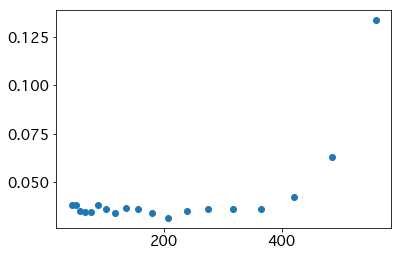

In [105]:
nhits = np.array([cnts[i][i] for i in range(len(cnts))])
y_err_err = 1/np.sqrt(nhits) # x_mean

sel = x_mean > 0

plt.plot(x_mean[sel],y_err_err[sel],'o')

In [106]:
sel = y_err > 10
sel &= x_mean < 520

tres_params_1, pcov = curve_fit(tres_func, x_mean[sel], y_err[sel], p0 = [15000], sigma = 1/y_err_err[sel])
tres_params_2, pcov = curve_fit(tres_func_2, x_mean[sel], y_err[sel], p0 = [15000,50], sigma = 1/y_err_err[sel])
tres_params_3, pcov = curve_fit(tres_func_3, x_mean[sel], y_err[sel], p0 = [15000,0,50], sigma = 1/y_err_err[sel])

# xs = np.linspace(x_mean.min()*0.8, x_mean.max()*1.2,100)
# plt.plot(x_mean[sel],y_err[sel], 'o')
# plt.plot(xs, tres_func_2(xs, *tres_params_2), label = 'Fit with sigma_floor')

print tres_params_2
print tres_params_3

[14049.67089924    40.41946768]
[10366.90549365    13.86897134    51.95517219]


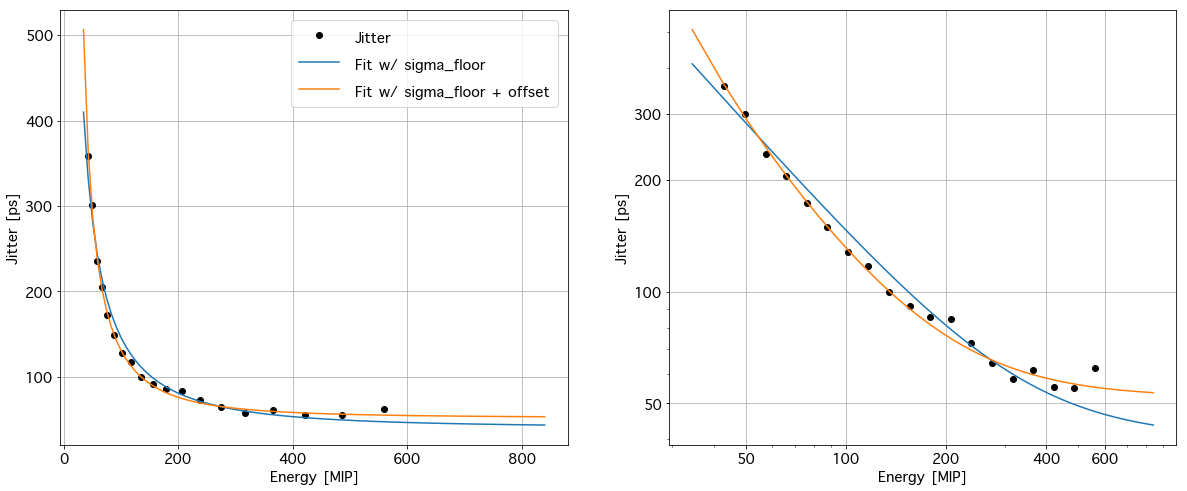

In [107]:
plt.figure(figsize = (20,8))

xs = np.linspace(x_mean.min()*0.8, x_mean.max()*1.5,100)

plt.subplot(121)
plt.plot(x_mean, y_err, 'ko', label = 'Jitter')
plt.plot(xs, tres_func_2(xs, *tres_params_2), label = 'Fit w/ sigma_floor')
plt.plot(xs, tres_func_3(xs, *tres_params_3), label = 'Fit w/ sigma_floor + offset')

plt.xlabel('Energy [MIP]')
plt.ylabel('Jitter [ps]')

#plt.ylim(40,500)

plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(x_mean, y_err, 'ko', label = 'Jitter')
plt.plot(xs, tres_func_2(xs, *tres_params_2), label = 'Fit w/ sigma_floor')
plt.plot(xs, tres_func_3(xs, *tres_params_3), label = 'Fit w/ sigma_floor + offset')

plt.xlabel('Energy [MIP]')
plt.ylabel('Jitter [ps]')

plt.xscale('log')
plt.xticks([50, 100,200,400,600])
plt.gca().get_xaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.yscale('log')
#plt.ylim(40,500)

plt.yticks([50,100,200,300])
plt.gca().get_yaxis().set_major_formatter(mpl.ticker.ScalarFormatter())

plt.grid()

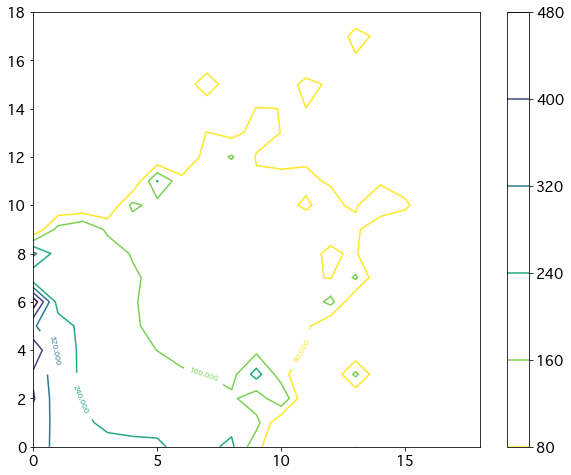

In [110]:
plt.figure(figsize = (10,8))

cs = plt.contour(counts.T, cmap = 'viridis_r')#[25, 50,1000])#, **kwargs)

plt.clabel(cs, inline=1, fontsize=10)


plt.colorbar()